# Analysis of the "infinite" Cech complex

In [124]:
# Various Imports
import warnings
from time import time
from tqdm import tqdm
from gudhi.datasets.generators import points
from gudhi import SimplexTree, AlphaComplex, bottleneck_distance, representations
import gudhi
from scipy.spatial.distance import cdist
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Plot
import matplotlib.pyplot as plt
import tikzplotlib


def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim


width = 600


def tikzplotlib_fix_ncols(obj):
    """
    workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
    """
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    for child in obj.get_children():
        tikzplotlib_fix_ncols(child)

# warnings.filterwarnings('ignore')


# The various complex studied. 
We use the alpha complex instead of the Cech complex since it leads to the same barcode with less computations.

In [125]:
def rips_euclidean(data_points):
    distance_matrix = cdist(data_points, data_points, 'euclidean')
    cplx = SimplexTree.create_from_array(distance_matrix)
    cplx.expansion(2)
    cplx.compute_persistence()
    return cplx


def cech_euclidean(data_points):
    ac = AlphaComplex(points=data_points)
    cplx = ac.create_simplex_tree()
    # Update the filtration values to be coherent with Cech complex persistence.
    for simplex, filtration in cplx.get_filtration():
        cplx.assign_filtration(simplex, 2 * np.sqrt(filtration))
    cplx.compute_persistence()
    return cplx


def rips_infinite(data_points):
    distance_matrix = cdist(data_points, data_points, 'chebyshev')
    cplx = SimplexTree.create_from_array(distance_matrix)
    cplx.expansion(2)
    cplx.compute_persistence()
    return cplx


## Different dataset generation for stability and expressivity test 

In [126]:
# Parameters
mu, sigma = 0, 1
noise_mu = 0


def datasets_gaussian(nb_points, nb_datasets, noise_sigma, dim=2):
    datasets = []
    datasets_noised = []

    for i in range(nb_datasets):
        # regular dataset
        dataset = np.random.normal(mu, sigma, (nb_points, dim))
        datasets.append(list(dataset))

        # add gaussian noise to test stability
        noise = np.random.normal(noise_mu, noise_sigma, (nb_points, dim))
        dataset_noised = dataset + noise
        datasets_noised.append(list(dataset_noised))

    return datasets, datasets_noised


In [127]:
# Parameters
low, high = 0, 1


def datasets_uniform(nb_points, nb_datasets, noise_sigma, dim=2):
    datasets = []
    datasets_noised = []

    for i in range(nb_datasets):
        # regular dataset
        dataset = np.random.uniform(low, high, (nb_points, dim))
        datasets.append(list(dataset))

        # add gaussian noise to test stability
        noise = np.random.uniform(-noise_sigma, noise_sigma, (nb_points, dim))
        dataset_noised = dataset + noise
        datasets_noised.append(list(dataset_noised))

    return datasets, datasets_noised


In [128]:
# Parameters
low_x, high_x = 0, 1
low_y, high_y = 0, 1


def datasets_ml(nb_points_ml, nb_datasets_ml, noise,  noise_x, noise_y):
    datasets_circle = []
    datasets_nocircle = []
    for i in range(nb_datasets_ml):
        # no circle dataset
        points_x = np.random.uniform(low_x, high_x, nb_points_ml)
        points_y = np.random.uniform(low_y, high_y, nb_points_ml)
        dataset = list(zip(points_x, points_y))
        datasets_nocircle.append(dataset)

        # circle dataset
        points_x = np.random.uniform(low_x, high_x, int(nb_points_ml * noise))
        points_y = np.random.uniform(low_y, high_y, int(nb_points_ml * noise))
        noise_circle_x = np.random.uniform(-noise_x,
                                           noise_x, int(nb_points_ml * (1 - noise)))
        noise_circle_y = np.random.uniform(-noise_y,
                                           noise_y, int(nb_points_ml * (1 - noise)))
        theta = np.random.uniform(
            0, 2 * np.pi, int(nb_points_ml * (1 - noise)))
        circle_x = [0.5 + 0.25 * np.cos(theta[i]) + noise_circle_x[i]
                    for i in range(int(nb_points_ml * (1 - noise)))]
        circle_y = [0.5 + 0.25 * np.sin(theta[i]) + noise_circle_y[i]
                    for i in range(int(nb_points_ml * (1 - noise)))]
        x = list(points_x) + circle_x
        y = list(points_y) + circle_y
        dataset = list(zip(x, y))
        datasets_circle.append(dataset)
    return datasets_circle, datasets_nocircle


## Stability test

In [129]:
# Stability test (Bottleneck distance with respect to small variation between the regular cech and the infinite rips)

def stability_test(datasets, datasets_noised, nb_datasets, verbose=False):
    avg_dist_cech = 0
    avg_dist_rips_inf = 0
    avg_dist_rips_euc = 0
    max_dist_cech = 0
    max_dist_rips_inf = 0
    max_dist_rips_euc = 0

    # for i in tqdm(range(nb_datasets)):
    for i in range(nb_datasets):
        cech = cech_euclidean(datasets[i])
        cech_noised = cech_euclidean(datasets_noised[i])
        avg_dist_cech += bottleneck_distance(cech.persistence_intervals_in_dimension(
            1), cech_noised.persistence_intervals_in_dimension(1))
        max_dist_cech = max(max_dist_cech, bottleneck_distance(
            cech.persistence_intervals_in_dimension(1), cech_noised.persistence_intervals_in_dimension(1)))

        rips_inf = rips_infinite(datasets[i])
        rips_inf_noised = rips_infinite(datasets_noised[i])
        avg_dist_rips_inf += bottleneck_distance(rips_inf.persistence_intervals_in_dimension(
            1), rips_inf_noised.persistence_intervals_in_dimension(1))
        max_dist_rips_inf = max(max_dist_rips_inf, bottleneck_distance(
            rips_inf.persistence_intervals_in_dimension(1), rips_inf_noised.persistence_intervals_in_dimension(1)))

        rips_euc = rips_euclidean(datasets[i])
        rips_euc_noised = rips_euclidean(datasets_noised[i])
        avg_dist_rips_euc += bottleneck_distance(rips_euc.persistence_intervals_in_dimension(
            1), rips_euc_noised.persistence_intervals_in_dimension(1))
        max_dist_rips_euc = max(max_dist_rips_euc, bottleneck_distance(
            rips_euc.persistence_intervals_in_dimension(1), rips_euc_noised.persistence_intervals_in_dimension(1)))
    avg_dist_cech /= nb_datasets
    avg_dist_rips_inf /= nb_datasets
    avg_dist_rips_euc /= nb_datasets

    if verbose:
        print(f"Average bottleneck distance for cech is {avg_dist_cech}")
        print(
            f"Average bottleneck distance for rips infinite is {avg_dist_rips_inf}")
        print(
            f"Average bottleneck distance for rips euclidean is {avg_dist_rips_euc}")
        print(f"Max bottleneck distance for cech is {max_dist_cech}")
        print(
            f"Max bottleneck distance for rips infinite is {max_dist_rips_inf}")
        print(
            f"Max bottleneck distance for rips euclidean is {max_dist_rips_euc}")

    return avg_dist_cech, avg_dist_rips_euc, avg_dist_rips_inf


In [130]:
# Parameters
nb_points = 100
nb_datasets = 100
noise_sigma = 0.01

# Tests
datasets, datasets_noised = datasets_gaussian(
    nb_points, nb_datasets, noise_sigma)
stability_test(datasets, datasets_noised, nb_datasets, verbose=True)
datasets, datasets_noised = datasets_uniform(
    nb_points, nb_datasets, noise_sigma)
stability_test(datasets, datasets_noised, nb_datasets, verbose=True)


Average bottleneck distance for cech is 0.030004550946598013
Average bottleneck distance for rips infinite is 0.029561923709348393
Average bottleneck distance for rips euclidean is 0.029565959344222632
Max bottleneck distance for cech is 0.053740544645938026
Max bottleneck distance for rips infinite is 0.047797421720429556
Max bottleneck distance for rips euclidean is 0.053740544645938026
Average bottleneck distance for cech is 0.01321783790303924
Average bottleneck distance for rips infinite is 0.013824541273255346
Average bottleneck distance for rips euclidean is 0.013764341650610317
Max bottleneck distance for cech is 0.018929963846230247
Max bottleneck distance for rips infinite is 0.019195022285401347
Max bottleneck distance for rips euclidean is 0.018716042204168698


(0.01321783790303924, 0.013764341650610317, 0.013824541273255346)

In [160]:
noises = [0.05 * i for i in range(20)]
nb_points = 100
nb_datasets = 100

avg_dist_cech_euclidean_list = []
avg_dist_rips_infinite_list = []
avg_dist_rips_euclidean_list = []
for noise in tqdm(noises):
    datasets, datasets_noised = datasets_gaussian(
        nb_points, nb_datasets, noise)
    avg_dist_cech, avg_dist_rips, avg_dist_rips_inf = stability_test(
        datasets, datasets_noised, nb_datasets)
    avg_dist_cech_euclidean_list.append(avg_dist_cech)
    avg_dist_rips_infinite_list.append(avg_dist_rips)
    avg_dist_rips_euclidean_list.append(avg_dist_rips_inf)


100%|██████████| 20/20 [04:15<00:00, 12.77s/it]


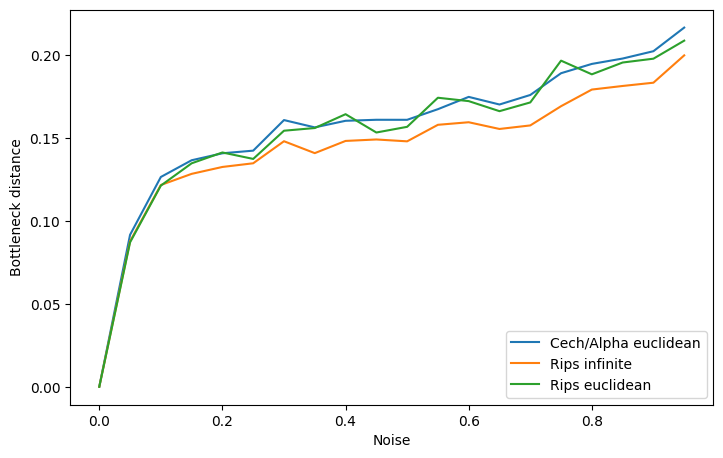

In [161]:
fig, ax = plt.subplots(1, 1, figsize=set_size(width))
ax.plot(noises, avg_dist_cech_euclidean_list, label="Cech/Alpha euclidean")
ax.plot(noises, avg_dist_rips_infinite_list, label="Rips infinite")
ax.plot(noises, avg_dist_rips_euclidean_list, label="Rips euclidean")
ax.set_xlabel('Noise')
ax.set_ylabel('Bottleneck distance')
ax.legend(loc='lower right')
# plt.show()
tikzplotlib_fix_ncols(fig)
tikzplotlib.save("stability_gaussian.tex")


In [162]:
noises = [0.05 * i for i in range(20)]
nb_points = 100
nb_datasets = 100

avg_dist_cech_euclidean_list = []
avg_dist_rips_infinite_list = []
avg_dist_rips_euclidean_list = []
for noise in tqdm(noises):
    datasets, datasets_noised = datasets_uniform(nb_points, nb_datasets, noise)
    avg_dist_cech, avg_dist_rips, avg_dist_rips_inf = stability_test(
        datasets, datasets_noised, nb_datasets)
    avg_dist_cech_euclidean_list.append(avg_dist_cech)
    avg_dist_rips_infinite_list.append(avg_dist_rips)
    avg_dist_rips_euclidean_list.append(avg_dist_rips_inf)


100%|██████████| 20/20 [04:17<00:00, 12.85s/it]


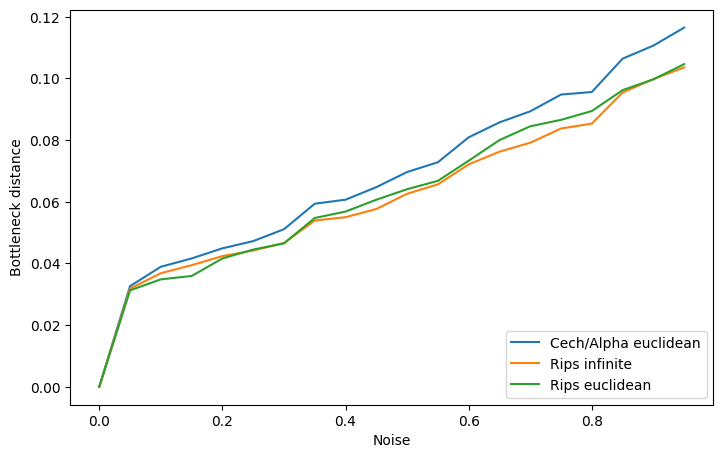

In [163]:
fig, ax = plt.subplots(1, 1, figsize=set_size(width))
ax.plot(noises, avg_dist_cech_euclidean_list, label="Cech/Alpha euclidean")
ax.plot(noises, avg_dist_rips_infinite_list, label="Rips infinite")
ax.plot(noises, avg_dist_rips_euclidean_list, label="Rips euclidean")
ax.set_xlabel('Noise')
ax.set_ylabel('Bottleneck distance')
ax.legend(loc='lower right')
# plt.show()
tikzplotlib_fix_ncols(fig)
tikzplotlib.save("stability_uniform.tex")


# Expressivity test 

In [133]:
# Expressive power test (Find dataset where it learns better than regular rips)

def expressive_power(complex_circle, complex_nocircle, nb_datasets_ml):
    PI = representations.PersistenceImage(resolution=[100, 100])
    pis = PI.fit_transform([c.persistence_intervals_in_dimension(
        1) for c in complex_circle] + [c.persistence_intervals_in_dimension(1) for c in complex_nocircle])
    # plt.imshow(np.flip(np.reshape(pis[0], [100,100]), 0))
    # plt.show()
    # plt.imshow(np.flip(np.reshape(pis[nb_datasets_ml], [100,100]), 0))
    # plt.show()
    labels = [0] * nb_datasets_ml + [1] * nb_datasets_ml
    X_train, X_test, y_train, y_test = train_test_split(
        pis, labels, test_size=0.40, random_state=42)
    lr = LogisticRegression()
    lr.fit(X_train, y_train)
    return lr.score(X_test, y_test)


In [134]:
nb_iter = 2
nb_points_ml = 100
noise = 0.4
noise_x = 0.01
noise_y = 0.01
nb_datasets_ml = 100


100%|██████████| 20/20 [11:04<00:00, 33.24s/it]


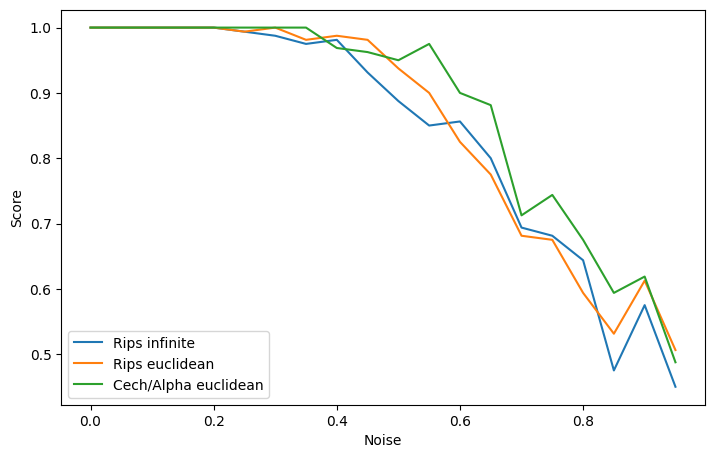

In [135]:
expressive_power_rips_infinite = []
expressive_power_cech_euclidean = []
expressive_power_rips_euclidean = []
noises = [0.05 * i for i in range(20)]
for noise in tqdm(noises):
    tmp_rips_infinite = 0
    tmp_cech_euclidean = 0
    tmp_rips_euclidean = 0
    for _ in range(nb_iter):
        datasets_circle, datasets_nocircle = datasets_ml(
            nb_points_ml, nb_datasets_ml, noise, noise_x, noise_y)

        complex_circle = [rips_infinite(dataset)
                          for dataset in datasets_circle]
        complex_nocircle = [rips_infinite(dataset)
                            for dataset in datasets_nocircle]
        tmp_rips_infinite += expressive_power(
            complex_circle, complex_nocircle, nb_datasets_ml)

        complex_circle = [cech_euclidean(dataset)
                          for dataset in datasets_circle]
        complex_nocircle = [cech_euclidean(dataset)
                            for dataset in datasets_nocircle]
        tmp_cech_euclidean += expressive_power(
            complex_circle, complex_nocircle, nb_datasets_ml)

        complex_circle = [rips_euclidean(dataset)
                          for dataset in datasets_circle]
        complex_nocircle = [rips_euclidean(dataset)
                            for dataset in datasets_nocircle]
        tmp_rips_euclidean += expressive_power(
            complex_circle, complex_nocircle, nb_datasets_ml)

    tmp_rips_infinite /= nb_iter
    expressive_power_rips_infinite.append(tmp_rips_infinite)
    tmp_cech_euclidean /= nb_iter
    expressive_power_cech_euclidean.append(tmp_cech_euclidean)
    tmp_rips_euclidean /= nb_iter
    expressive_power_rips_euclidean.append(tmp_rips_euclidean)

fig, ax = plt.subplots(1, 1, figsize=set_size(width))
ax.plot(noises, expressive_power_rips_infinite, label="Rips infinite")
ax.plot(noises, expressive_power_rips_euclidean, label="Rips euclidean")
ax.plot(noises, expressive_power_cech_euclidean, label="Cech/Alpha euclidean")
# ax.xlabel('Noise')
ax.set_xlabel('Noise')
# ax.ylabel('Score')
ax.set_ylabel('Score')
ax.legend(loc='best')
# plt.show()
# fig = plt.figure(figsize=set_size(width))
tikzplotlib_fix_ncols(fig)
tikzplotlib.save("expressivity.tex")


# Speed test

### First plot : varying the number of points

In [149]:
nb_points_list = [50 * i for i in range(2, 11)]
noise = 0.4
noise_sigma = 0.01
nb_datasets = 1
times_rips = []
times_cech = []
times_rips_inf = []
for nb_points in nb_points_list:
    tmp_rips_inf = 0
    tmp_cech = 0
    tmp_rips = 0
    datasets, datasets_noised = datasets_gaussian(
        nb_points, nb_datasets, noise_sigma)
    t = time()
    complex_rips_infinite = [rips_infinite(dataset) for dataset in datasets]
    tmp_rips_inf += time() - t
    t = time()
    complex_cech = [cech_euclidean(dataset) for dataset in datasets]
    tmp_cech += time() - t
    t = time()
    complex_rips = [rips_euclidean(dataset) for dataset in datasets]
    tmp_rips = time() - t

    times_rips_inf.append(tmp_rips_inf)
    times_cech.append(tmp_cech)
    times_rips.append(tmp_rips)


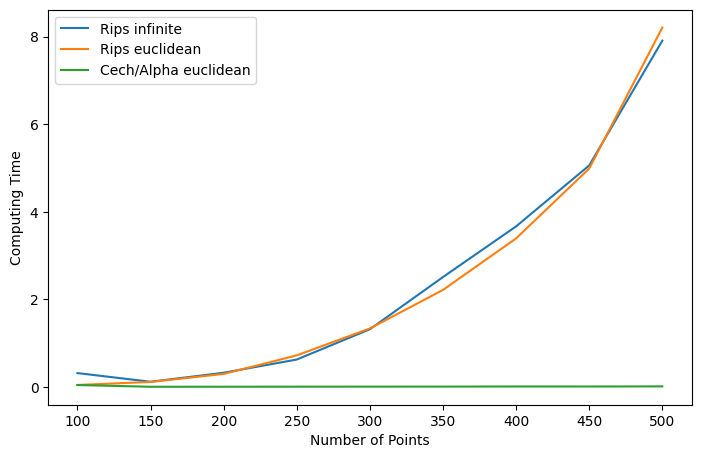

In [150]:
fig, ax = plt.subplots(1, 1, figsize=set_size(width))
ax.plot(nb_points_list, times_rips_inf, label="Rips infinite")
ax.plot(nb_points_list, times_rips, label="Rips euclidean")
ax.plot(nb_points_list, times_cech, label="Cech/Alpha euclidean")
# ax.xlabel('Noise')
ax.set_xlabel('Number of Points')
# ax.ylabel('Score')
ax.set_ylabel('Computing Time')
ax.legend(loc='best')
# plt.show()
# fig = plt.figure(figsize=set_size(width))
tikzplotlib_fix_ncols(fig)
tikzplotlib.save("computing_times.tex")


### Second plot: varying the dimension

In [139]:
dims = [i for i in range(2, 7)]
nb_points = 100
noise_sigma = 0.01
nb_datasets = 1
times_rips = []
times_cech = []
times_rips_inf = []
for d in dims:
    tmp_rips_inf = 0
    tmp_cech = 0
    tmp_rips = 0
    datasets, datasets_noised = datasets_gaussian(
        nb_points, nb_datasets, noise_sigma, dim=d)
    t = time()
    complex_rips_inf = [rips_infinite(dataset) for dataset in datasets]
    tmp_rips_inf += time() - t
    t = time()
    complex_cech = [cech_euclidean(dataset) for dataset in datasets]
    tmp_cech += time() - t
    t = time()
    complex_rips = [rips_euclidean(dataset) for dataset in datasets]
    tmp_rips = time() - t
    times_rips_inf.append(tmp_rips_inf)
    times_cech.append(tmp_cech)
    times_rips.append(tmp_rips)


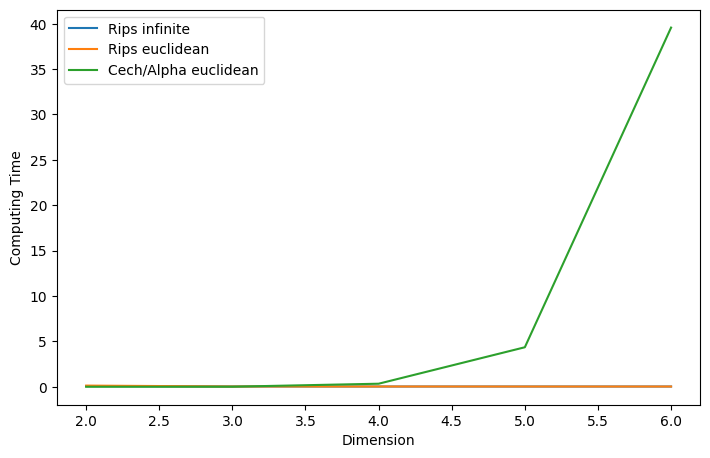

In [140]:
fig, ax = plt.subplots(1, 1, figsize=set_size(width))
ax.plot(dims, times_rips_inf, label="Rips infinite")
ax.plot(dims, times_rips, label="Rips euclidean")
ax.plot(dims, times_cech, label="Cech/Alpha euclidean")
ax.set_xlabel('Dimension')
ax.set_ylabel('Computing Time')
ax.legend(loc='best')
# plt.show()
# fig = plt.figure(figsize=set_size(width))
tikzplotlib_fix_ncols(fig)
tikzplotlib.save("computing_times2.tex")


# Various plots to illustrate the report

In [141]:
# # Generate 50 points on a sphere in R^3
# data_points = points.sphere(n_samples = 3, ambient_dim = 3, radius = 1, sample = "random")


In [142]:
# # Make data
# u = np.linspace(0, 2 * np.pi, 100)
# v = np.linspace(0, np.pi, 100)

# fig, ax = plt.subplots(1, 1, figsize=set_size(width))
# ax = fig.add_subplot(projection='3d')

# eps = 0.1
# for point in data_points:
#     a = point[0] + (eps * np.outer(np.cos(u), np.sin(v)))
#     b = point[1] + (eps * np.outer(np.sin(u), np.sin(v)))
#     c = point[2] + (eps * np.outer(np.ones(np.size(u)), np.cos(v)))
#     # Plot the surface
#     ax.plot_surface(a, b, c, color = 'blue')

# # Set an equal aspect ratio
# ax.set_aspect('equal')
# tikzplotlib_fix_ncols(fig)
# tikzplotlib.save("cech.tex")
# # plt.show()


In [143]:
# # Make data
# u = np.linspace(0, 2 * np.pi, 100)
# v = np.linspace(0, np.pi, 100)

# def get_cube():
#     phi = np.arange(1,10,2)*np.pi/4
#     Phi, Theta = np.meshgrid(phi, phi)

#     x = np.cos(Phi)*np.sin(Theta)
#     y = np.sin(Phi)*np.sin(Theta)
#     z = np.cos(Theta)/np.sqrt(2)
#     return x,y,z

# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')

# eps = 0.15
# for point in data_points:
#     x,y,z = get_cube()

#     # Change the centroid of the cube from zero to values in data frame
#     x = x*eps + point[0]
#     y = y*eps + point[1]
#     z = z*eps + point[2]
#     ax.plot_surface(x, y, z, color = 'blue')
#     ax.set_zlabel("z")

# plt.xlabel("x")
# plt.ylabel("y")

# plt.show()


usetex mode requires TeX.


[[1.03077641 1.07830088]
 [1.41421356 1.41637143]
 [1.11803399 1.58113883]
 [1.60078106 1.69675395]
 [1.75       1.78972763]
 [2.13600094 2.21401434]
 [2.23606798 2.42240698]
 [2.5        2.51945555]]
[[0.         0.77620873]
 [0.         0.90553851]
 [0.         0.90553851]
 [0.         0.94339811]
 [0.         1.06066017]
 [0.         1.06066017]
 [0.         1.22576507]
 [0.         1.5132746 ]
 [0.         2.01556444]
 [0.         2.01556444]
 [0.                inf]]


<Figure size 640x480 with 0 Axes>

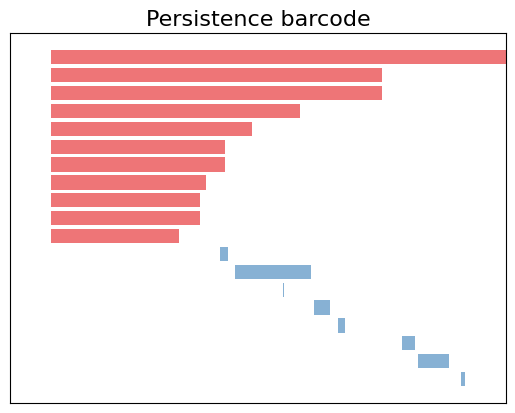

In [144]:
data_points_example = [[1.5, 2], [1.6, 2.9], [2.25, 1.25], [2.5, 3], [
    3, 2], [4.5, 1.8], [5.25, 2], [5, 1], [6, 4], [4, 5], [4.25, 3]]
cplx = cech_euclidean(data_points_example)
cplx.compute_persistence()
pers = cplx.persistence()
print(cplx.persistence_intervals_in_dimension(1))
print(cplx.persistence_intervals_in_dimension(0))
fig = plt.figure()
gudhi.plot_persistence_barcode(pers)
plt.xticks([])
plt.yticks([])
tikzplotlib_fix_ncols(fig)
tikzplotlib.save("barcode.tex")


In [145]:
data_points_example = [[0, 0], [0, 1]]
cplx_cech = cech_euclidean(data_points_example)
for filtered_value in cplx_cech.get_filtration():
    print(filtered_value)


([0], 0.0)
([1], 0.0)
([0, 1], 1.0)


In [146]:
cplx_rips = rips_euclidean(data_points_example)
for filtered_value in cplx_rips.get_filtration():
    print(filtered_value)


([0], 0.0)
([1], 0.0)
([0, 1], 1.0)


In [147]:
cplx_rips_inf = rips_infinite(data_points_example)
for filtered_value in cplx_rips_inf.get_filtration():
    print(filtered_value)


([0], 0.0)
([1], 0.0)
([0, 1], 1.0)
